In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import shutil
from tensorflow import keras
import seaborn as sns
import random
from keras.models import load_model
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [4]:
import os
import shutil
import numpy as np
from sklearn.model_selection import train_test_split

def split_dataset_by_class(source_dirs, class_names, output_dir, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1, seed=1321):
    # Create main output directories
    train_dir = os.path.join(output_dir, 'train')
    val_dir = os.path.join(output_dir, 'val')
    test_dir = os.path.join(output_dir, 'test')

    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)

    # For each class (glaucoma and normal)
    for class_dir, class_name in zip(source_dirs, class_names):
        # Create class subdirectories within train/val/test
        os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
        os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)
        os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

        # Get all files for this class
        files = os.listdir(class_dir)

        # First split: training and the rest
        train_files, temp_files = train_test_split(
            files, train_size=train_ratio, random_state=seed
        )

        # Second split: validation and test
        val_ratio_adjusted = val_ratio / (val_ratio + test_ratio)
        val_files, test_files = train_test_split(
            temp_files, train_size=val_ratio_adjusted, random_state=seed
        )

        # Copy files to class subdirectories
        for file in train_files:
            shutil.copy2(os.path.join(class_dir, file), os.path.join(train_dir, class_name, file))

        for file in val_files:
            shutil.copy2(os.path.join(class_dir, file), os.path.join(val_dir, class_name, file))

        for file in test_files:
            shutil.copy2(os.path.join(class_dir, file), os.path.join(test_dir, class_name, file))

        print(f"Class {class_name}: {len(train_files)} training, {len(val_files)} validation, {len(test_files)} test")

# Example usage with your combined directories
glaucoma_dir = '/content/drive/MyDrive/Leetcode images/datasets/ACRIMA/glaucoma'
normal_dir = '/content/drive/MyDrive/Leetcode images/datasets/ACRIMA/normal'

# Run the function
split_dataset_by_class(
    source_dirs=[glaucoma_dir, normal_dir],
    class_names=['glaucoma', 'normal'],
    output_dir='images',
    seed=1321
)

Class glaucoma: 316 training, 40 validation, 40 test
Class normal: 247 training, 31 validation, 31 test


In [5]:
img_height=256
img_width=256
batch_size=32

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [7]:
#from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255,
shear_range = 0.15,
zoom_range = 0.15,
horizontal_flip = True)
train_ds = datagen.flow_from_directory(
    'images/train',
    target_size = (img_height, img_width),
    batch_size = batch_size,
    class_mode='categorical',
    shuffle=False)

val_ds = datagen.flow_from_directory(
    'images/val',
    target_size = (img_height, img_width),
    batch_size = batch_size,
    class_mode='categorical',
    shuffle=False)

test_ds = datagen.flow_from_directory(
    'images/test',
    target_size = (img_height, img_width),
    batch_size = batch_size,
    class_mode='categorical',
    shuffle=False)

Found 563 images belonging to 2 classes.
Found 71 images belonging to 2 classes.
Found 71 images belonging to 2 classes.


In [8]:
import joblib

In [12]:
# Load model and preprocessors
cdr_model = joblib.load('ensemble_cdr_model.pkl')
selector = joblib.load('selector.pkl')
scaler = joblib.load('scaler.pkl')

In [9]:
def extract_features(img_path):
    img = cv2.imread(img_path)
    if img is None:
        return None
    # Preprocessing
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    enhanced = clahe.apply(gray)

    # Vessel detection
    edges = cv2.Canny(enhanced, 50, 150)
    vessel_density = np.mean(edges)

    # Texture features
    glcm = cv2.calcHist([enhanced], [0], None, [256], [0,256])
    glcm = cv2.normalize(glcm, None).flatten()

    # Shape features
    moments = cv2.HuMoments(cv2.moments(edges)).flatten()

    return [
        np.mean(enhanced),          # Global intensity
        np.std(enhanced),           # Contrast
        vessel_density,             # Edge density
        enhanced[116:166, 116:166].mean(),  # Center region
        glcm[100],                  # Texture measure
        moments[0],                 # Hu moment 1
        moments[1]                  # Hu moment 2
    ]

In [10]:
def find_cdr(img_path):
  features = extract_features(img_path)
  features_scaled = scaler.transform([features])
  features_selected = selector.transform(features_scaled)
  # Predict CDR
  cdr_pred = cdr_model.predict(features_selected)[0]
  return cdr_pred

In [11]:
import cv2

In [ ]:
# 2) Install any missing dependencies (if utils/cdr_utils needs OpenCV, scikit‑image, etc.)
!pip install opencv-python scikit-image tqdm

# 3) Adjust this to point at where your “images/” folder actually lives
IMG_ROOT = '/content/images'
CSV_OUT  = '/content/images/labels_with_cdr.csv'

import pandas as pd
import glob
from pathlib import Path

rows = []
for split in ['train', 'val', 'test']:
    for label in ['glaucoma', 'normal']:
        pattern = f"{IMG_ROOT}/{split}/{label}/*.*"
        file_list = glob.glob(pattern)
        print(f"→ Found {len(file_list)} images for {split}/{label}")
        for img_path in file_list:
            try:
                cdr_value = find_cdr(img_path)
            except Exception as e:
                print(f"  ⚠️ Failed on {img_path}: {e}")
                continue
            rows.append({
                'path': img_path,
                'label': 1 if label=='glaucoma' else 0,
                'cdr': cdr_value
            })

# 4) Save out the CSV
df = pd.DataFrame(rows)
Path(Path(CSV_OUT).parent).mkdir(parents=True, exist_ok=True)
df.to_csv(CSV_OUT, index=False)
print(f"✅ Saved {len(df)} rows to {CSV_OUT}")


→ Found 316 images for train/glaucoma
→ Found 247 images for train/normal
→ Found 40 images for val/glaucoma
→ Found 31 images for val/normal
→ Found 40 images for test/glaucoma
→ Found 31 images for test/normal
✅ Saved 705 rows to /content/images/labels_with_cdr.csv


In [14]:
IMG_ROOT = '/content/images'             # adjust if needed
CSV_PATH = os.path.join(IMG_ROOT, 'labels_with_cdr.csv')
batch_size = 32
class_names = ['normal', 'glaucoma']
num_classes = len(class_names)

In [15]:
import pandas as pd

In [16]:
df = pd.read_csv(CSV_PATH)
# Ensure correct types
df['cdr'] = df['cdr'].astype(np.float32)
df['label'] = df['label'].astype(int)

# Split by folder names
df_train = df[df['path'].str.contains(f"{os.sep}train{os.sep}")]
df_val   = df[df['path'].str.contains(f"{os.sep}val{os.sep}")]
df_test  = df[df['path'].str.contains(f"{os.sep}test{os.sep}")]


In [17]:
import tensorflow as tf

In [18]:
def df_to_data(df_split):
    paths = df_split['path'].tolist()
    labels = tf.keras.utils.to_categorical(df_split['label'], num_classes)
    cdrs = df_split['cdr'].values.reshape(-1, 1)
    return paths, labels, cdrs

train_image_paths, train_labels, train_cdr_values = df_to_data(df_train)
val_image_paths,   val_labels,   val_cdr_values   = df_to_data(df_val)
test_image_paths,  test_labels,  test_cdr_values  = df_to_data(df_test)


In [19]:
def preprocess(image_path, cdr, label):
    # Read, decode, resize, normalize
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [256, 256]) / 255.0
    # Cast and reshape cdr
    cdr = tf.cast(cdr, tf.float32)
    cdr = tf.reshape(cdr, [1])
    return (image, cdr), label


In [20]:
def make_dataset(paths, cdrs, labels, shuffle=True):
    ds = tf.data.Dataset.from_tensor_slices((paths, cdrs, labels))
    ds = ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    if shuffle:
        ds = ds.shuffle(buffer_size=len(paths))
    return ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

train_ds = make_dataset(train_image_paths, train_cdr_values, train_labels, shuffle=True)
val_ds   = make_dataset(val_image_paths,   val_cdr_values,   val_labels,   shuffle=False)
test_ds  = make_dataset(test_image_paths,  test_cdr_values,  test_labels,  shuffle=False)


In [21]:
from keras.layers import (
    Conv2D, MaxPooling2D, Flatten,
    Dense, Dropout, BatchNormalization,
    Input, Concatenate, Lambda
)
from keras.models import Model

In [22]:
img_input = Input(shape=(256, 256, 3), name='image_input')
# CNN backbone
tmp = Conv2D(32, (3,3), activation='relu')(img_input)
tmp = MaxPooling2D((2,2))(tmp)
tmp = Conv2D(32, (3,3), activation='relu')(tmp)
tmp = MaxPooling2D((2,2))(tmp)
tmp = Flatten()(tmp)

# CDR input (single scalar)
cdr_input = Input(shape=(1,), name='cdr_input')
# --- Repeat CDR 32 times to create a feature vector ---
cdr_tiled = Lambda(lambda t: tf.tile(t, [1, 32]), name='cdr_tile')(cdr_input)

# Concatenate the CNN features with the tiled CDR vector
merged = Concatenate(name='feature_concat')([tmp, cdr_tiled])

# Dense head
h = Dense(512, activation='relu', name='dense_1')(merged)
h = BatchNormalization(name='bn_1')(h)
h = Dense(256, activation='relu', name='dense_2')(h)
h = Dropout(0.25, name='dropout')(h)
outputs = Dense(num_classes, activation='softmax', name='output')(h)

# Instantiate & compile
classifier = Model(inputs=[img_input, cdr_input], outputs=outputs, name='GlaucomaNet')
classifier.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
classifier.summary()

Model: "GlaucomaNet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 254, 254,  │        896 │ image_input[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 127, 127,  │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 125, 125,  │      9,248 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 62, 62,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cdr_input           │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 123008)    │          0 │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cdr_tile (Lambda)   │ (None, 32)        │          0 │ cdr_input[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ feature_concat      │ (None, 123040)    │          0 │ flatten[0][0],    │
│ (Concatenate)       │                   │            │ cdr_tile[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 512)       │ 62,996,992 │ feature_concat[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_1                │ (None, 512)       │      2,048 │ dense_1[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 256)       │    131,328 │ bn_1[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 2)         │        514 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 63,141,026 (240.86 MB)

 Trainable params: 63,140,002 (240.86 MB)

 Non-trainable params: 1,024 (4.00 KB)

Epoch 1/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 22s 425ms/step - accuracy: 0.7137 - loss: 0.6164 - val_accuracy: 0.5634 - val_loss: 6.3598
Epoch 2/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 115ms/step - accuracy: 0.8692 - loss: 0.3026 - val_accuracy: 0.6761 - val_loss: 0.7135
Epoch 3/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 96ms/step - accuracy: 0.9113 - loss: 0.1840 - val_accuracy: 0.6620 - val_loss: 1.5737
Epoch 4/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 11s 112ms/step - accuracy: 0.9518 - loss: 0.1437 - val_accuracy: 0.8028 - val_loss: 0.6976
Epoch 5/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 96ms/step - accuracy: 0.9446 - loss: 0.1519 - val_accuracy: 0.4507 - val_loss: 5.4200
Epoch 6/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 96ms/step - accuracy: 0.9214 - loss: 0.2089 - val_accuracy: 0.4789 - val_loss: 3.5972
Epoch 7/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 97ms/step - accuracy: 0.9402 - loss: 0.1192 - val_accuracy: 0.7887 - val_loss: 0.5583
Epoch 8/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 117ms/step - accuracy: 0.9459 - loss: 0.1253 - val_accuracy: 0.84

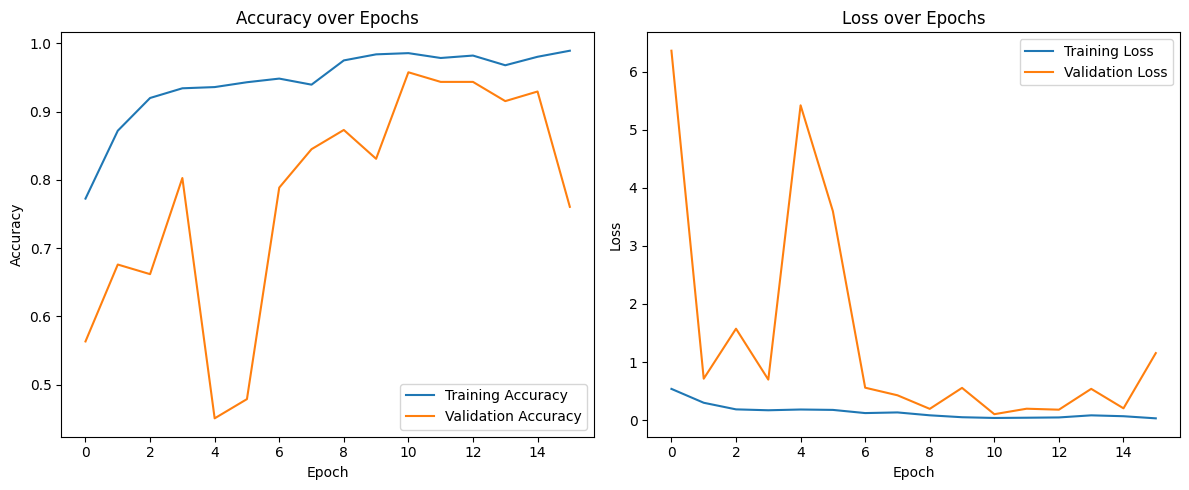

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - accuracy: 0.9781 - loss: 0.0598 
Test loss: 0.0623, Test accuracy: 0.9718
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step


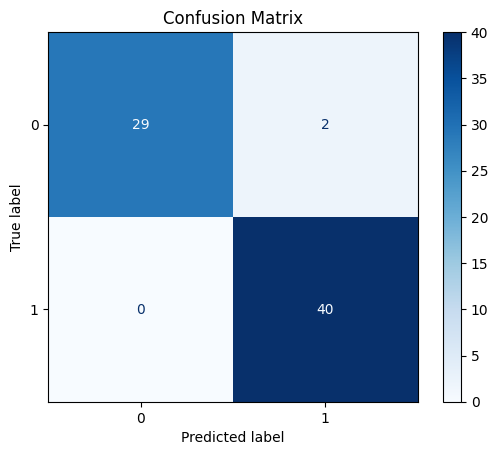

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.callbacks import EarlyStopping

# Early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Training the model with early stopping
model_info = classifier.fit(
    train_ds,
    steps_per_epoch=int(np.ceil(len(train_image_paths) / batch_size)),
    epochs=30,
    validation_data=val_ds,
    validation_steps=int(np.ceil(len(val_image_paths) / batch_size)),
    callbacks=[early_stop]
)

# Plotting training & validation accuracy and loss
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(model_info.history['accuracy'], label='Training Accuracy')
plt.plot(model_info.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(model_info.history['loss'], label='Training Loss')
plt.plot(model_info.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Testing
test_metrics = classifier.evaluate(
    test_ds,
    steps=int(np.ceil(len(test_image_paths) / batch_size))
)
print(f"Test loss: {test_metrics[0]:.4f}, Test accuracy: {test_metrics[1]:.4f}")

# Generate predictions and labels for confusion matrix
y_pred = []
y_true = []

for images, labels in test_ds:
    preds = classifier.predict(images)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(np.argmax(labels.numpy(), axis=1))  # Assuming one-hot encoded labels

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()
